# Introduction

As we need to scrap a lot of data, we will performe the initial analysis for milestone 2 on a subset of movies and the actors that play in those movies. This is done to show the viability of our approaches. Then as soon as we have the full set of the data, we will scale up our analysis.

In [40]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import matplotlib.animation as animation
from IPython.display import HTML

In [73]:
df_movies_subset=pd.read_pickle('movies_subset.pkl')
df_actors_awards=pd.read_pickle('actors_awards_subset.pkl')
df_movies=pd.read_csv('data/title.basics.tsv', sep='\t',na_values= '\\N')
df_actors=pd.read_csv('data/name.basics.tsv.gz', sep='\t')
df_ratings=pd.read_csv('data/title.ratings.tsv.gz', sep='\t')

C:\Users\souhail\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3058: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


## Raw Data

We start by merging the different data sets with information about the movies into one data set.

### Movies data

In [7]:
#adding our scrapped data to the original movie data set
movies_data=df_movies_subset.merge(df_movies,how='inner', on='tconst')
movies_data=movies_data.merge(df_ratings, how='left', on='tconst').drop(['titleType','isAdult','endYear'],axis=1)

NameError: name 'df_ratings' is not defined

In [ ]:
with pd.option_context('display.max_columns', 50):
    display(movies_data.head())

#### Description of the data

- tconst: Unique imdb identifier of each movie, given as string
- stars: Three main actors playing in the movie , given as list of strings, scraped 
- oscarWins: Number of Oscars awarded to the movie, given as float, scraped 
- nominations: Number of general award nominations, given as float, scraped
- wins: Number of awards won, given as integer, scraped
- releaseDate: Date release of the movie, given as DateTime, scraped
- releaseCountry: Country of release, given as string, scraped
- plotKeywords: Keywords describing the plot of the movie, given as list of strings, scraped
- budget: production budget of the movie, given as string, scraped
- worldwideGross: Wordlwide revenue, given as string, scrapped
- metascore: Scores are assigned to movie's reviews of large group of the world's most respected critics, and weighted average are applied to summarize their opinions range, given as float, scraped
- musicProducer: Producer of the music in the movie, string, scraped
- primaryTitle: English title, string
- originalTitle: Original title, string
- startYear: Year of release, integer
- runtimeMinutes: Runtime of the movie in minutes, string, scraped
- genres: genres the movie can be attributed to, string
- averageRating: Average rating of the movie given by imbd users, float
- numVotes: Number of users that have scored the movie, float



### Actors data

In [5]:
df_actors_awards.head()

nconst  year       category      w_n  \
0  nm0309470  2005          David  Nominee   
1  nm0309470  1968   Golden Plate   Winner   
2  nm0309470  2005    Golden Ciak   Winner   
3  nm0309470  1967   Golden Globe   Winner   
4  nm0309470  1968  Golden Goblet   Winner   

                                         description               movie  \
0  Best Supporting Actress (Migliore Attrice non ...         Cuore sacro   
1                                                             Grazie zia   
2  Best Supporting Actress (Migliore Attrice Non ...         Cuore sacro   
3                    Best Actress (Migliore Attrice)  Svegliati e uccidi   
4                    Best Actress (Migliore Attrice)          Grazie zia   

      tconst  
0  tt0429898  
1  tt0063033  
2  tt0429898  
3  tt0061049  
4  tt0063033

In [6]:
df_actors.head()

nconst      primaryName birthYear deathYear  \
0  nm0000001     Fred Astaire        \N        \N   
1  nm0000002    Lauren Bacall        \N        \N   
2  nm0000003  Brigitte Bardot        \N        \N   
3  nm0000004     John Belushi        \N        \N   
4  nm0000005   Ingmar Bergman        \N        \N   

                primaryProfession                           knownForTitles  
0  soundtrack,actor,miscellaneous  tt0043044,tt0053137,tt0072308,tt0050419  
1              actress,soundtrack  tt0038355,tt0037382,tt0071877,tt0117057  
2     actress,soundtrack,producer  tt0059956,tt0057345,tt0054452,tt0049189  
3         actor,writer,soundtrack  tt0080455,tt0078723,tt0077975,tt0072562  
4           writer,director,actor  tt0050986,tt0069467,tt0050976,tt0083922

## Data Wrangling

### Movie Data

In movies_data we need to change a few columns to achive our goal:

- releaseDate, here we only want the month, to see if there is seasonality, the release year is given seperately
- for budget and wordwideGross: These are given in different currency depending on the movie. Furthermore, they are not always given in the same currency for a given movie. To proceed we first need to convert the strings into integers and then we would need to convert all the numbers into dollars to make them comparable.
- runtime: Transforme to integers
- genres: Transforme to list of strings

Furthermore, there are some columns we are not interested in, that we can drop.

In [91]:
#extracting month
movies_data['releaseMonth']=movies_data['releaseDate'].map(lambda x:  x.month if x is not None else None)

We will extract the release year from the release date and we will drop the startyear feature.

In [92]:
#extracting year
movies_data['releaseYear']=movies_data['releaseDate'].map(lambda x:  int(x.year) if x is not None else None)

In [8]:
#first we need to change worldwideGross and budget to integers
import re
    
def to_int(x):
    if x ==None:
        val=None
        dollar= False
    else:
        val= int(re.sub('[^0-9,]', "", x).replace(",", ""))
        if x.startswith('$'):
            dollar= True
        else:
            dollar= False
    return val, dollar
    
movies_data['budget'],movies_data['budget_in_dollar'] = zip(*movies_data['budget'].apply(to_int))
movies_data['worldwideGross'], movies_data['worldwideGross_in_dollar']= zip(*movies_data['worldwideGross']\
                                                                            .apply(to_int))
#now we can calculate the revenue percentage
movies_data['revenue']=movies_data['worldwideGross']/movies_data['budget']-1

In [10]:
#only extracting one genre
#Needs to be improved as genres are just orderd in alphabetical order not importance
movies_data.genres=movies_data.genres.str.split(',')

In [11]:
with pd.option_context('display.max_columns', 50):
    display(movies_data.head())

tconst                              stars  oscarWins  nominations  wins  \
0  tt0014799  [nm0265550, nm0370407, nm0550195]          0            0     0   
1  tt0014843  [nm0427659, nm0107574, nm0421138]          0            0     0   
2  tt0014809  [nm0267916, nm0119572, nm0055809]          0            0     0   
3  tt0014751             [nm0403710, nm0744408]          0            0     0   
4  tt0014812  [nm0556953, nm0531962, nm0645941]          0            0     0   

  releaseDate releaseCountry plotKeywords budget worldwideGross metascore  \
0  1924-05-31             UK           []   None           None      None   
1  1924-08-24            USA           []   None           None      None   
2  1924-04-08            USA           []   None           None      None   
3        None           None           []   None           None      None   
4  1924-12-28            USA           []   None           None      None   

  musicProducer titleType                primaryTitle  \
0          None     movie            The Conspirators   
1          None     movie           The Desert Outlaw   
2          None     movie              Crossed Trails   
3          None     movie  La buenaventura de Pitusín   
4          None     movie                    Curlytop   

                originalTitle  isAdult startYear endYear runtimeMinutes  \
0            The Conspirators        0      1924      \N             \N   
1           The Desert Outlaw        0      1924      \N             60   
2              Crossed Trails        0      1924      \N             50   
3  La buenaventura de Pitusín        0      1924      \N             \N   
4                    Curlytop        0      1924      \N             60   

             genres  budget_in_dollar  worldwideGross_in_dollar revenue  \
0    [Crime, Drama]             False                     False     NaN   
1         [Western]             False                     False     NaN   
2         [Western]             False                     False     NaN   
3              [\N]             False                     False     NaN   
4  [Drama, Romance]             False                     False     NaN   

   releaseMonth  
0           5.0  
1           8.0  
2           4.0  
3           NaN  
4          12.0

### Actors Data

Out of the awards data of the actors we want to build a score for the actors. We will score the wins and nominations in the top 10 movies awards according to https://www.therichest.com/most-popular/top-10-most-prestigious-movie-awards-in-the-world/ higher then the wins and nominations in the other awards.

In [ ]:
best_award=['Golden Globe','Oscar', 'Golden Lion','Grand Jury Prize','Golden Leopard','European Film Award', 'Filmfare Award','Golden Berlin Bear','BAFTA Film Award',"Palme d'Or"]

In [ ]:
df_actors_awards['Important']=[False]*df_actors_awards.shape[0]

In [ ]:
df_actors_awards['Important'][df_actors_awards.category.isin(best_award)]=True

In [ ]:
df_actors_awards.head()

In the actors data set we want to have the gender as an aditional feature

In [ ]:
#splitting professions
df_actors.primaryProfession=df_actors.primaryProfession.str.split(',')

In [ ]:
def m_f(x):
    if type(x) is list:
        if 'actor' in x:
            return 'M'
        elif 'actress' in x:
            return 'F'
        else:
            return None
    else:
        return None

In [ ]:
df_actors['gender']=df_actors.primaryProfession.apply(m_f)

In [ ]:
df_actors.head()

## Data exploration

Now that we have the data sets cleaned we can do the initial data analysis.

#### Actors data

#### Movies data

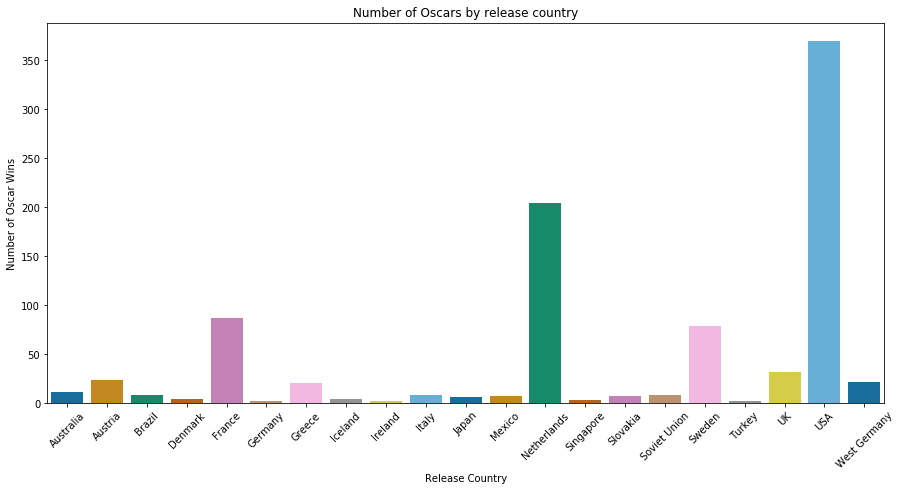

In [50]:
plt.figure(figsize=(15,7))
chart=sns.barplot(x='releaseCountry',y='oscarWins',data=pd.DataFrame(movies_data[movies_data['oscarWins']>0].groupby('releaseCountry')['oscarWins'].sum().reset_index()),palette='colorblind')
chart.set_xticklabels(chart.get_xticklabels(),rotation=45)
plt.title('Number of Oscars by release country')
plt.xlabel('Release Country')
plt.ylabel('Number of Oscar Wins')
plt.show()

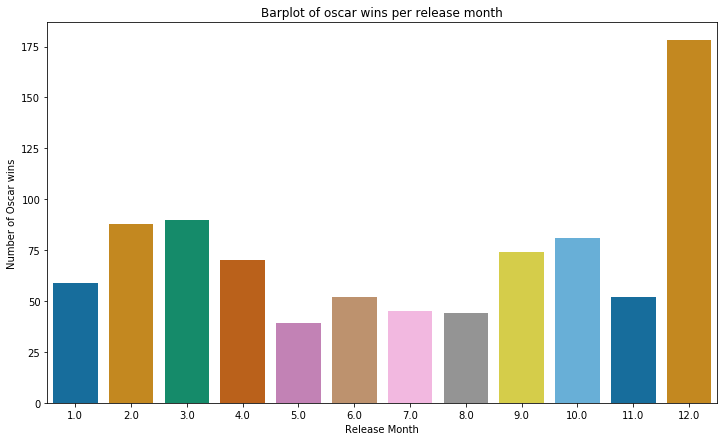

In [51]:
plt.figure(figsize=(12,7))
sns.barplot('releaseMonth', 'oscarWins', data=movies_data.groupby('releaseMonth')['oscarWins'].sum().reset_index(),palette='colorblind')
plt.ylabel('Number of Oscar wins')
plt.xlabel('Release Month')
plt.title('Barplot of oscar wins per release month')
plt.show()

In [93]:
year_month=movies_data.groupby(['releaseMonth','releaseYear']).sum()

In [94]:
Year_month_oscar=year_month.pivot_table(index='releaseMonth',columns='releaseYear',values='oscarWins').fillna(0)

In [95]:
Year_month_oscar.head()

releaseYear   1894.0  1898.0  1899.0  1900.0  1901.0  1903.0  1904.0  1905.0  \
releaseMonth                                                                   
1.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
2.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
3.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
4.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   
5.0              0.0     0.0     0.0     0.0     0.0     0.0     0.0     0.0   

releaseYear   1906.0  1907.0  ...  2011.0  2012.0  2013.0  2014.0  2015.0  \
releaseMonth                  ...                                           
1.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
2.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
3.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
4.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   
5.0              0.0     0.0  ...     0.0     0.0     0.0     0.0     0.0   

releaseYear   2016.0  2017.0  2018.0  2019.0  2021.0  
releaseMonth                                          
1.0              0.0     0.0     0.0     0.0     0.0  
2.0              0.0     0.0     0.0     0.0     0.0  
3.0              0.0     0.0     0.0     0.0     0.0  
4.0              0.0     0.0     0.0     0.0     0.0  
5.0              0.0     0.0     0.0     0.0     0.0  

[5 rows x 123 columns]

In [67]:
oscars_heat=Year_month_oscar.iloc[1:,35:]

Text(0.5, 1, 'Number of oscar wining movies subject to the release date')

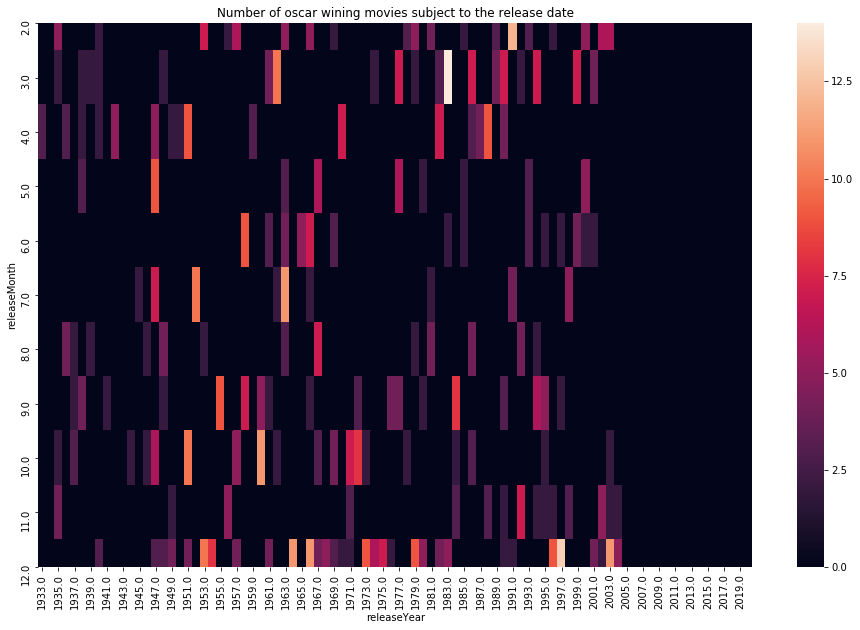

In [68]:
fig, ax = plt.subplots(figsize=(16,10)) 
sns.heatmap(oscars_heat,ax=ax)
plt.title('Number of oscar wining movies subject to the release date')

In [24]:
movies_data.metascore.describe()

count     4950
unique      98
top         61
freq       119
Name: metascore, dtype: object

In [27]:
movies_data['metascore']=movies_data.apply(lambda x: to_int(x.metascore),axis=1)

In [28]:
movies_data.metascore.describe()

count    4950.000000
mean       57.622222
std        18.594554
min         1.000000
25%        45.000000
50%        59.000000
75%        71.000000
max       100.000000
Name: metascore, dtype: float64

Text(0.5, 1.0, 'histogram of the metascore')

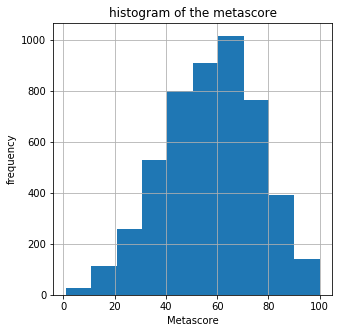

In [29]:
ax, fig= plt.subplots(figsize=(5,5))
movies_data.metascore.hist()
plt.xlabel('Metascore')
plt.ylabel('frequency')
plt.title('histogram of the metascore')

Text(0.5, 1.0, 'Scatter plot of the number of wins vs metascore')

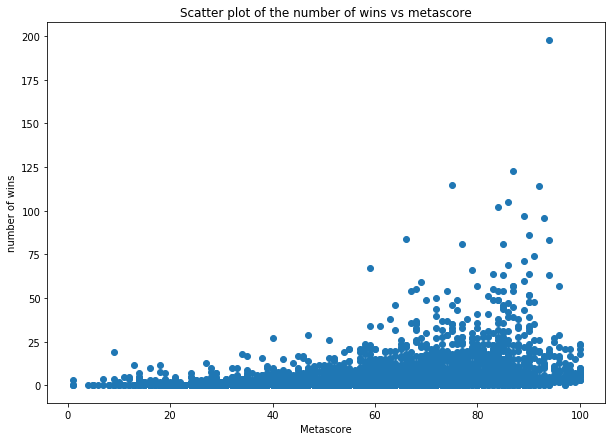

In [30]:
ax,fig=plt.subplots(figsize=(10,7))
plt.scatter(movies_data.metascore,movies_data.wins)
plt.xlabel('Metascore')
plt.ylabel('number of wins')
plt.title('Scatter plot of the number of wins vs metascore')

In [104]:
#Correlation:
cor=movies_data.corr()

Text(0.5, 1, 'The correlation matrix of the movies dataset')

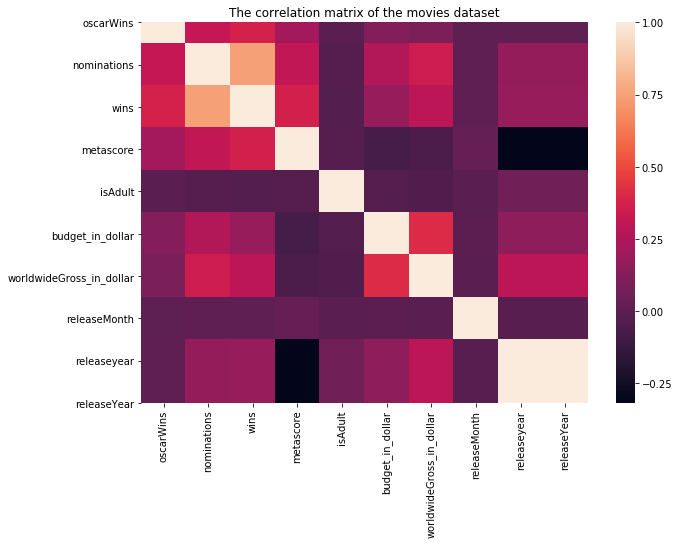

In [108]:
ax, fig= plt.subplots(figsize=(10,7))
sns.heatmap(cor)
plt.title('The correlation matrix of the movies dataset')

We will inspect the evolution of movie's genre.
We will use the IMDB dataset df_movies imported in the begining.

In [74]:
movies=pd.DataFrame(df_movies)
#Extracting the movies
movies=movies[(movies.titleType=='movie')]

As you can see, IMDB assigns a list of genres for each movie ordered alphabetically. So a single movie will be counted more than once when we will count the number of movies in each genre class.

In [75]:
#The genre feature is a list of strings, so we will split it and explode the data set subject to genres:
movies.genres= movies.apply(lambda x: str(x['genres']).split(',') , axis=1)
movies=movies.explode('genres')

In [76]:
#Taking the features that we need to inspect the evolution.
movies_sh= movies[['tconst','startYear','genres']]

In [78]:
movies_sh=movies_sh.rename({'startYear':'year'},axis=1)

In [96]:
#Removing the None genre
movies_sh=movies_sh[movies_sh.genres!=None]

In [102]:
#We will group by the data subject to year and genres and we will get the number of movies corresponding to each year and genre
#by applying the size function
#reset_index will remove the hierarchical indexing so that we get in each raw the year and the genres
year_genre=pd.DataFrame(movies_sh.groupby(['year','genres']).size())
year_genre=year_genre.reset_index()
year_genre=year_genre.rename({0:'nbr'},axis=1)
year_genre.head(5)

year       genres  nbr
0  1894.0      Romance    1
1  1897.0  Documentary    2
2  1897.0         News    2
3  1897.0        Sport    2
4  1898.0  Documentary    8

Now we will prepare the framework to plot the animated evolution of the genre through the years.
We used ticker and animation from the Matplotlib library and HTML from IPYTHON.display to construct our animation.

In [98]:
current_year=2000
df=year_genre[pd.to_numeric(year_genre.year)==current_year].sort_values(by='nbr',ascending=True)
colors = dict(zip(df.year.unique(), ['#adb0ff', '#ffb3ff', '#90d595', '#e48381','aafbff', '#f7bb5f', '#eafb50']))
group_lk = df['genres'].to_dict()

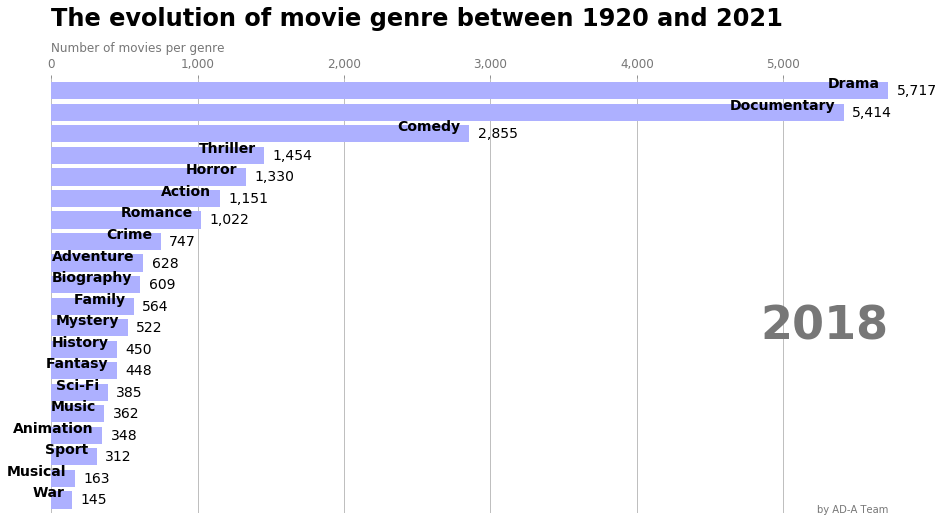

In [99]:
fig, ax = plt.subplots(figsize=(15, 8))
#the function draw_barchart will returns the barplot of the movies genre distribution for a given year.
def draw_barchart(year):

    df = year_genre[year_genre['year'].eq(year)].sort_values(by='nbr', ascending=True).tail(20)

    ax.clear()

    ax.barh(df['genres'], df['nbr'],color='#adb0ff')

    dx = df['nbr'].max()/100

    for i, (nbr, genre) in enumerate(zip(df['nbr'], df['genres'])):

        ax.text(nbr-dx, i,     genre,           size=14, weight=600, ha='right', va='bottom')
        ax.text(nbr+dx, i,     f'{nbr:,.0f}',  size=14, ha='left',  va='center')

    # ... polished styles

    ax.text(1, 0.4, year, transform=ax.transAxes, color='#777777', size=46, ha='right', weight=800)

    ax.text(0, 1.06, 'Number of movies per genre', transform=ax.transAxes, size=12, color='#777777')

    ax.xaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))

    ax.xaxis.set_ticks_position('top')

    ax.tick_params(axis='x', colors='#777777', labelsize=12)

    ax.set_yticks([])

    ax.margins(0, 0.01)

    ax.grid(which='major', axis='x', linestyle='-')

    ax.set_axisbelow(True)

    ax.text(0, 1.12, 'The evolution of movie genre between 1920 and 2021',

            transform=ax.transAxes, size=24, weight=600, ha='left')
    
    ax.text(1, 0, 'by AD-A Team', transform=ax.transAxes, ha='right',

            color='#777777', bbox=dict(facecolor='white', alpha=0.8, edgecolor='white'))

    plt.box(False)

    

draw_barchart(2018)

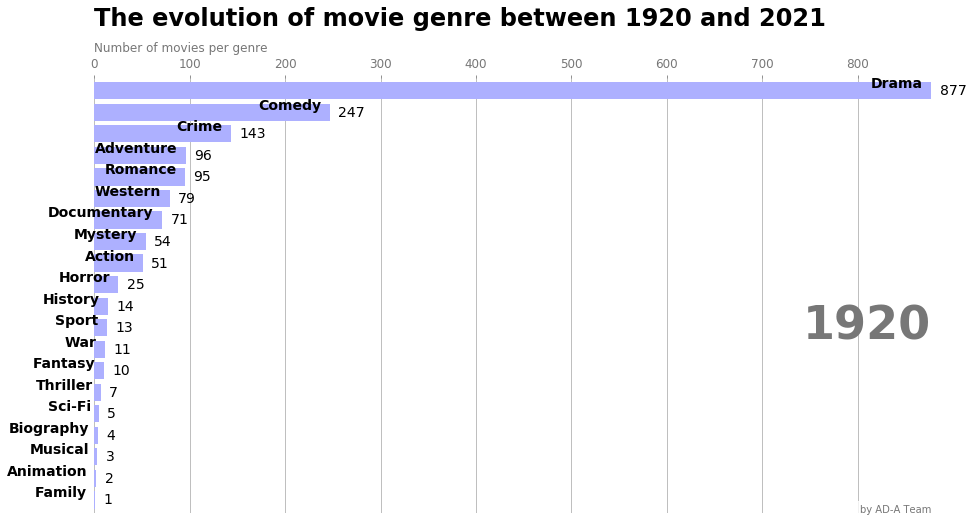

In [103]:
#The animated barplot will be constructed via FuncAnimation 
fig, ax = plt.subplots(figsize=(15, 8))
animator = animation.FuncAnimation(fig, draw_barchart, frames=range(1920, 2019))
HTML(animator.to_jshtml()) 